In [107]:
import pandas as pd
import datetime as dt
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error,r2_score

In [108]:
df= pd.read_csv('datos_arreglados.csv',index_col=0,parse_dates=True)
df

<ipython-input-108-e404f7da5ad4>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df= pd.read_csv('datos_arreglados.csv',index_col=0,parse_dates=True)


,date,item,category,department,stores,region,week,year,is_holidays,units_sold,sell_price,total_sales
0,2013-07-08,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,0,0.0,12.7414,0.0000
1,2013-07-15,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,1,0.0,12.7414,0.0000
2,2013-07-22,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,29,2013,0,4.0,10.9858,43.9432
3,2013-07-29,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,30,2013,0,6.0,10.9858,65.9148
4,2013-08-05,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,31,2013,0,0.0,10.9858,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
6610508,2016-03-28,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village(PHI_3),Philadelphia,12,2016,1,22.0,1.2000,26.4000
6610509,2016-04-04,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village(PHI_3),Philadelphia,13,2016,0,17.0,1.2000,20.4000
6610510,2016-04-11,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village(PHI_3),Philadelphia,14,2016,0,6.0,1.2000,7.2000
6610511,2016-04-18,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village(PHI_3),Philadelphia,15,2016,0,0.0,1.2000,0.0000


In [109]:
df.stores.unique()


array(['South_End(BOS_1)', 'Roxbury(BOS_2)', 'Back_Bay(BOS_3)',
       'Greenwich_Village(NYC_1)', 'Harlem(NYC_2)', 'Tribeca(NYC_3)',
       'Brooklyn(NYC_4)', 'Midtown_Village(PHI_1)', 'Yorktown(PHI_2)',
       'Queen_Village(PHI_3)'], dtype=object)

In [139]:
# Prophet funciona mejor con eventos, asi que extraeremos los eventos mas importantes de nuestro csv de eventos.

df_events= pd.read_csv('daily_calendar_with_events.csv')
df_events

,date,weekday,weekday_int,d,event
0,2011-01-29,Saturday,1,d_1,NaN
1,2011-01-30,Sunday,2,d_2,NaN
2,2011-01-31,Monday,3,d_3,NaN
3,2011-02-01,Tuesday,4,d_4,NaN
4,2011-02-02,Wednesday,5,d_5,NaN
...,...,...,...,...,...
1908,2016-04-20,Wednesday,5,d_1909,NaN
1909,2016-04-21,Thursday,6,d_1910,NaN
1910,2016-04-22,Friday,7,d_1911,NaN
1911,2016-04-23,Saturday,1,d_1912,NaN


In [140]:
# extraemos el df con los eventos filtrados:

df_events.dropna(inplace=True)

# cambiamos las columans para el prophet

df_events.rename(columns={'date':'ds','event':'holiday'},inplace=True)

df_events['ds']=pd.to_datetime(df_events['ds'])

# eliminamos las columnas que no interesan
df_events.drop(columns=['weekday','weekday_int','d'],inplace=True)
df_events

,ds,holiday
8,2011-02-06,SuperBowl
184,2011-08-01,Ramadan starts
299,2011-11-24,Thanksgiving
337,2012-01-01,NewYear
372,2012-02-05,SuperBowl
435,2012-04-08,Easter
538,2012-07-20,Ramadan starts
663,2012-11-22,Thanksgiving
703,2013-01-01,NewYear
736,2013-02-03,SuperBowl


In [153]:
# Aparte añadiremos otros eventos importantes y fechas que se han producido en las tres ciudades.

eventos = [
    {'fecha': '2011-11-25', 'evento': 'Black Friday'},
    {'fecha': '2012-11-23', 'evento': 'Black Friday'},
    {'fecha': '2013-11-29', 'evento': 'Black Friday'},
    {'fecha': '2014-11-28', 'evento': 'Black Friday'},
    {'fecha': '2015-11-27', 'evento': 'Black Friday'},
    {'fecha': '2016-11-25', 'evento': 'Black Friday'},
    {'fecha': '2017-11-24', 'evento': 'Black Friday'},
    {'fecha': '2011-10-31', 'evento': 'Halloween'},
    {'fecha': '2012-10-31', 'evento': 'Halloween'},
    {'fecha': '2013-10-31', 'evento': 'Halloween'},
    {'fecha': '2014-10-31', 'evento': 'Halloween'},
    {'fecha': '2015-10-31', 'evento': 'Halloween'},
    {'fecha': '2016-10-31', 'evento': 'Halloween'},
    {'fecha': '2017-10-31', 'evento': 'Halloween'},
    {'fecha': '2011-07-04', 'evento': 'Independence Day'},
    {'fecha': '2012-07-04', 'evento': 'Independence Day'},
    {'fecha': '2013-07-04', 'evento': 'Independence Day'},
    {'fecha': '2014-07-04', 'evento': 'Independence Day'},
    {'fecha': '2015-07-04', 'evento': 'Independence Day'},
    {'fecha': '2016-07-04', 'evento': 'Independence Day'},
    {'fecha': '2017-07-04', 'evento': 'Independence Day'},
    {'fecha': '2011-04-24', 'evento': 'Easter'},
    {'fecha': '2012-04-08', 'evento': 'Easter'},
    {'fecha': '2013-03-31', 'evento': 'Easter'},
    {'fecha': '2014-04-20', 'evento': 'Easter'},
    {'fecha': '2015-04-05', 'evento': 'Easter'},
    {'fecha': '2016-03-27', 'evento': 'Easter'},
    {'fecha': '2017-04-16', 'evento': 'Easter'},
    {'fecha': '2011-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2012-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2013-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2014-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2015-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2016-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2017-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2011-05-08', 'evento': "Mother's Day"},
    {'fecha': '2012-05-13', 'evento': "Mother's Day"},
    {'fecha': '2013-05-12', 'evento': "Mother's Day"},
    {'fecha': '2014-05-11', 'evento': "Mother's Day"},
    {'fecha': '2015-05-10', 'evento': "Mother's Day"},
    {'fecha': '2016-05-08', 'evento': "Mother's Day"},
    {'fecha': '2017-05-14', 'evento': "Mother's Day"},
    {'fecha': '2011-06-19', 'evento': "Father's Day"},
    {'fecha': '2012-06-17', 'evento': "Father's Day"},
    {'fecha': '2013-06-16', 'evento': "Father's Day"},
    {'fecha': '2014-06-15', 'evento': "Father's Day"},
    {'fecha': '2015-06-21', 'evento': "Father's Day"},
    {'fecha': '2016-06-19', 'evento': "Father's Day"},
    {'fecha': '2017-06-18', 'evento': "Father's Day"},
    {'fecha': '2011-12-25', 'evento': "Christmas"},
    {'fecha': '2012-12-25', 'evento': "Christmas"},
    {'fecha': '2013-12-25', 'evento': "Christmas"},
    {'fecha': '2014-12-25', 'evento': "Christmas"},
    {'fecha': '2015-12-25', 'evento': "Christmas"},
    {'fecha': '2016-12-25', 'evento': "Christmas"},
    {'fecha': '2017-12-25', 'evento': "Christmas"},
    {'fecha': '2011-11-06', 'evento': 'NYC Marathon'},
    {'fecha': '2012-11-04', 'evento': 'NYC Marathon'},
    {'fecha': '2013-11-03', 'evento': 'NYC Marathon'},
    {'fecha': '2014-11-02', 'evento': 'NYC Marathon'},
    {'fecha': '2015-11-01', 'evento': 'NYC Marathon'},
    {'fecha': '2016-11-06', 'evento': 'NYC Marathon'},
    {'fecha': '2017-11-05', 'evento': 'NYC Marathon'},
    {'fecha': '2011-04-18', 'evento': 'Boston Marathon'},
    {'fecha': '2012-04-16', 'evento': 'Boston Marathon'},
    {'fecha': '2013-04-15', 'evento': 'Boston Marathon'},
    {'fecha': '2014-04-21', 'evento': 'Boston Marathon'},
    {'fecha': '2015-04-20', 'evento': 'Boston Marathon'},
    {'fecha': '2016-04-18', 'evento': 'Boston Marathon'},
    {'fecha': '2017-04-17', 'evento': 'Boston Marathon'},
    {'fecha': '2011-06-26', 'evento': 'NYC Pride'},
    {'fecha': '2012-06-24', 'evento': 'NYC Pride'},
    {'fecha': '2013-06-30', 'evento': 'NYC Pride'},
    {'fecha': '2014-06-29', 'evento': 'NYC Pride'},
    {'fecha': '2015-06-28', 'evento': 'NYC Pride'},
    {'fecha': '2016-06-26', 'evento': 'NYC Pride'},
    {'fecha': '2017-06-25', 'evento': 'NYC Pride'},
    {'fecha': '2011-08-30', 'evento': "Eid al-Fitr"},
    {'fecha': '2012-08-19', 'evento': "Eid al-Fitr"},
    {'fecha': '2013-08-08', 'evento': "Eid al-Fitr"},
    {'fecha': '2014-07-28', 'evento': "Eid al-Fitr"},
    {'fecha': '2015-07-17', 'evento': "Eid al-Fitr"},
    {'fecha': '2016-07-06', 'evento': "Eid al-Fitr"},
    {'fecha': '2017-06-25', 'evento': "Eid al-Fitr"},
    {'fecha': '2011-12-20', 'evento': 'Hanukkah'},
    {'fecha': '2012-12-08', 'evento': 'Hanukkah'},
    {'fecha': '2013-11-27', 'evento': 'Hanukkah'},
    {'fecha': '2014-12-16', 'evento': 'Hanukkah'},
    {'fecha': '2015-12-06', 'evento': 'Hanukkah'},
    {'fecha': '2016-12-24', 'evento': 'Hanukkah'},
    {'fecha': '2017-12-12', 'evento': 'Hanukkah'},
]


In [154]:
# y creamos df con los eventos nuevos.

df_new_events= pd.DataFrame(eventos)

# cambiamos columnas para que sean las mismas que para nuestra futura df para prophet.
df_new_events.rename(columns={'fecha':'ds','evento':'holiday'},inplace=True)
# y el formato datetime
df_new_events['ds']=pd.to_datetime(df_new_events['ds'])


df_new_events

,ds,holiday
0,2011-11-25,Black Friday
1,2012-11-23,Black Friday
2,2013-11-29,Black Friday
3,2014-11-28,Black Friday
4,2015-11-27,Black Friday
...,...,...
93,2013-11-27,Hanukkah
94,2014-12-16,Hanukkah
95,2015-12-06,Hanukkah
96,2016-12-24,Hanukkah


In [160]:
# concatenamos las dos dataframes

df_events = pd.concat([df_events, df_new_events], ignore_index=True)
df_events

,ds,holiday
0,2011-02-06,SuperBowl
1,2011-08-01,Ramadan starts
2,2011-11-24,Thanksgiving
3,2012-01-01,NewYear
4,2012-02-05,SuperBowl
...,...,...
413,2013-11-27,Hanukkah
414,2014-12-16,Hanukkah
415,2015-12-06,Hanukkah
416,2016-12-24,Hanukkah


In [162]:
# Creamos 10 df con los datos de las distintas tiendas para hacer las distintas predicciones:

# BO
df_South_End_BOS_1 = df[df['stores'] == 'South_End(BOS_1)']
df_Roxury_BOS_2= df[df['stores'] == 'Roxbury(BOS_2)']
df_Back_Bay_BOS_3= df[df['stores'] == 'Back_Bay(BOS_3)']

# NY
df_Greenwich_Village_NYC_1= df[df['stores'] == 'Greenwich_Village(NYC_1)']
df_Harlem_NYC_2= df[df['stores'] == 'Harlem(NYC_2)']
df_Tribeca_NYC_3= df[df['stores'] == 'Tribeca(NYC_3)']
df_Brooklyn_NYC_4= df[df['stores'] == 'Brooklyn(NYC_4)']

# PHI
df_Midtown_Village_PHI_1= df[df['stores'] == 'Midtown_Village(PHI_1)']
df_Yorktown_PHI_2= df[df['stores'] == 'Yorktown(PHI_2)']
df_Queen_Village_PHI_3= df[df['stores'] == 'Queen_Village(PHI_3)']



## South End Boston


In [163]:
# empezaremos con el de South_End.

df_South_End_BOS_1

,date,item,category,department,stores,region,week,year,is_holidays,units_sold,sell_price,total_sales
0,2013-07-08,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,0,0.0,12.7414,0.0000
1,2013-07-15,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,1,0.0,12.7414,0.0000
2,2013-07-22,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,29,2013,0,4.0,10.9858,43.9432
3,2013-07-29,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,30,2013,0,6.0,10.9858,65.9148
4,2013-08-05,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,31,2013,0,0.0,10.9858,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
6609638,2016-03-28,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,South_End(BOS_1),Boston,12,2016,1,3.0,1.2000,3.6000
6609639,2016-04-04,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,South_End(BOS_1),Boston,13,2016,0,6.0,1.2000,7.2000
6609640,2016-04-11,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,South_End(BOS_1),Boston,14,2016,0,17.0,1.2000,20.4000
6609641,2016-04-18,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,South_End(BOS_1),Boston,15,2016,0,20.0,1.2000,24.0000


In [164]:
# Agrupamos por fecha y sumatorio de venta

df_prophet_BOS_1= pd.DataFrame(df_South_End_BOS_1.groupby('date')['total_sales'].sum().reset_index())
# Cambiamos los nombres de las columnas

df_prophet_BOS_1.rename(columns={'date':'ds','total_sales':'y'},inplace=True)

# formateamos tipos aceptables para prophet

df_prophet_BOS_1['ds']= pd.to_datetime(df_prophet_BOS_1['ds'])
df_prophet_BOS_1

,ds,y
0,2011-01-31,5577.6946
1,2011-02-07,50008.7733
2,2011-02-14,52285.3364
3,2011-02-21,51853.3517
4,2011-02-28,47467.8923
...,...,...
269,2016-03-28,88891.0019
270,2016-04-04,86682.7451
271,2016-04-11,94191.1113
272,2016-04-18,89399.5610


,ds,holiday
0,2011-02-06,SuperBowl
1,2011-08-01,Ramadan starts
2,2011-11-24,Thanksgiving
3,2012-01-01,NewYear
4,2012-02-05,SuperBowl
...,...,...
414,2014-12-16,Hanukkah
415,2015-12-06,Hanukkah
416,2016-12-24,Hanukkah
417,2017-12-12,Hanukkah


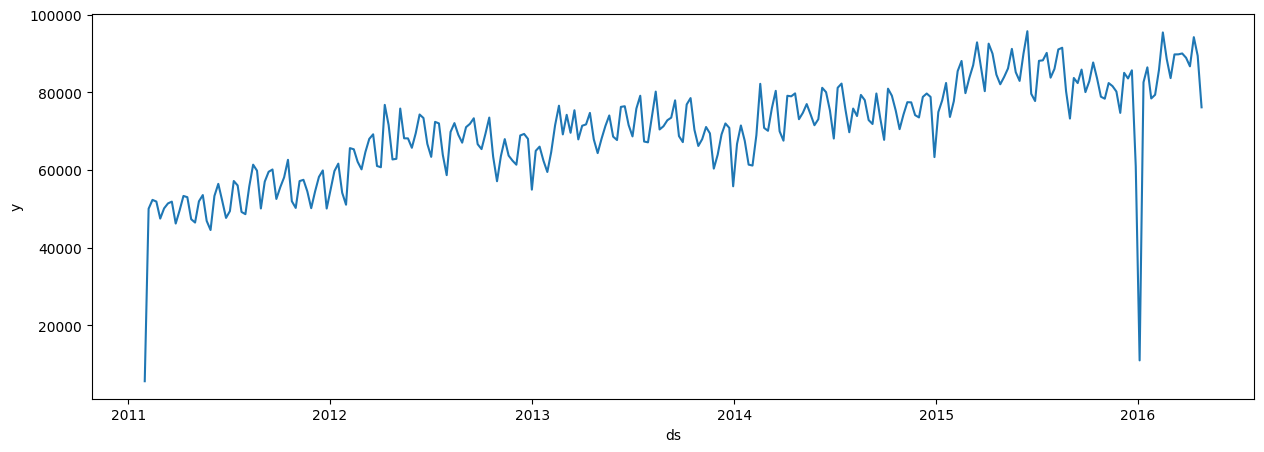

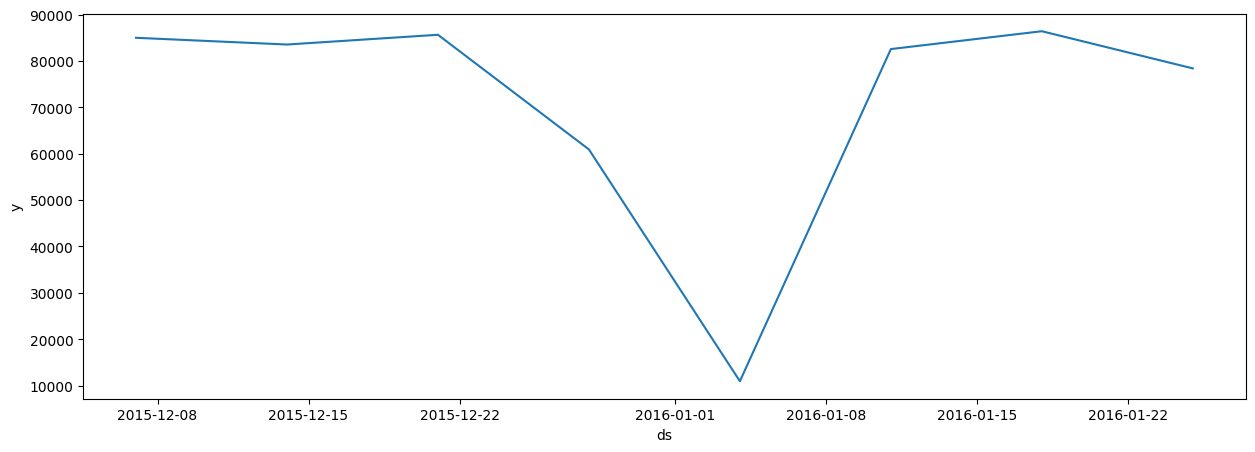

In [165]:
# vamos a representar graficamente las ventas a lo largo del tiempo

plt.figure(figsize=(15, 5))


sns.lineplot(data=df_prophet_BOS_1,x='ds',y='y')

# visualizamos en concreto los meses de diciembre 2015 y enero 2016

plt.figure(figsize=(15, 5))
sns.lineplot(data= df_prophet_BOS_1[(df_prophet_BOS_1['ds'] >= '2015-12-01') & (df_prophet_BOS_1['ds'] <= '2016-01-31')],x='ds',y='y')


# vemos que para el 10 de enero de 2016 existe un descenso en ventas considerable. No se si podria deberse a una tormenta invernal :
# Supertormenta Jonas (22 Enero 2016) importante notar que enero de 2016 fue el mes en el que ocurrió una gran tormenta de nieve en Estados Unidos, afectando principalmente a la región
#  del Atlántico Medio y el Noreste, incluyendo ciudades como Washington D.C., Filadelfia y Nueva York con 1-2.5 pies (12-30 pulgadas) de nieve​ (Wikipedia)​.


# he revisado en NY y pasa mas de lo mismo, asi que podria tener sentido. Añadimos el evento


# Crear un nuevo DataFrame con la fila que deseas agregar
new_row = pd.DataFrame({'ds': [pd.to_datetime('2016-01-07')], 'holiday': ['Jonas Superstorm']})

# Concatenar el nuevo DataFrame con df_events
df_events = pd.concat([df_events, new_row], ignore_index=True)

# Verificar el DataFrame resultante
display(df_events)


In [167]:
# instanciamos prophet

# y añadimos los dias de eventos especiales sacado de la lista de eventos(Superbowl,ramadan,Superstorm)
model = Prophet(holidays=df_events)


# Añadimos las vacaciones de US al modelo.

model.add_country_holidays('US')



# entrenamos el modelo

model.fit(df_prophet_BOS_1)



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkvr37sdn/nrm86oa8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkvr37sdn/o38uou79.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28343', 'data', 'file=/tmp/tmpkvr37sdn/nrm86oa8.json', 'init=/tmp/tmpkvr37sdn/o38uou79.json', 'output', 'file=/tmp/tmpkvr37sdn/prophet_modelnt0s3fko/prophet_model-20240408183248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [168]:
# hacemos prediccion para BOS_1

df_pred_BOS_1_fut= model.make_future_dataframe(periods=24,freq='W')


df_pred_BOS_1 = model.predict(df_pred_BOS_1_fut)


<Axes: xlabel='ds', ylabel='y'>

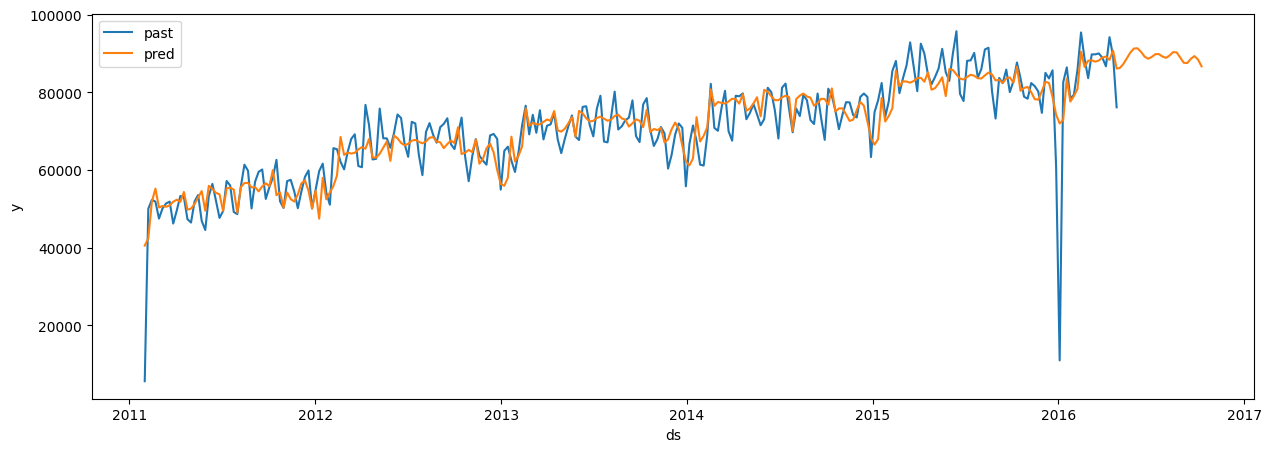

In [169]:
# representamos la prediccion respecto a los datos reales


plt.figure(figsize=(15, 5))
sns.lineplot(data=df_prophet_BOS_1,x='ds',y='y',label='past')

sns.lineplot(data=df_pred_BOS_1,x='ds',y='yhat',label='pred')

In [130]:
# hacemos prediccion para BOS_1

df_pred_BOS_1_fut= model.make_future_dataframe(periods=24,freq='W')


df_pred_BOS_1 = model.predict(df_pred_BOS_1_fut)


In [127]:
df_pred_BOS_1

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-31,45968.763357,32157.424203,49116.922424,45968.763357,45968.763357,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-5133.449628,-5133.449628,-5133.449628,0.0,0.0,0.0,40835.313729
1,2011-02-07,46235.574536,34993.082550,50948.701183,46235.574536,46235.574536,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-3207.046891,-3207.046891,-3207.046891,0.0,0.0,0.0,43028.527644
2,2011-02-14,46502.385715,38031.152052,54604.417514,46502.385715,46502.385715,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-488.979289,-488.979289,-488.979289,0.0,0.0,0.0,46013.406426
3,2011-02-21,46769.196894,46835.314291,63568.499429,46769.196894,46769.196894,0.0,0.0,0.0,0.0,...,5909.769067,5909.769067,5909.769067,2244.646823,2244.646823,2244.646823,0.0,0.0,0.0,54923.612785
4,2011-02-28,47036.008073,42901.414841,58504.026568,47036.008073,47036.008073,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,3716.011306,3716.011306,3716.011306,0.0,0.0,0.0,50752.019379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,2016-05-22,85888.220258,81752.122944,98265.189015,85880.757359,85891.800712,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,4194.385660,4194.385660,4194.385660,0.0,0.0,0.0,90082.605918
278,2016-05-29,85991.848396,82852.210984,99221.478195,85979.110562,85999.975183,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,5360.469203,5360.469203,5360.469203,0.0,0.0,0.0,91352.317599
279,2016-06-05,86095.476534,83693.095268,99680.058346,86075.620738,86109.166025,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,5283.784622,5283.784622,5283.784622,0.0,0.0,0.0,91379.261156
280,2016-06-12,86199.104672,82624.182170,97738.271142,86174.626075,86218.686743,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,4055.157548,4055.157548,4055.157548,0.0,0.0,0.0,90254.262221


<Axes: xlabel='ds', ylabel='y'>

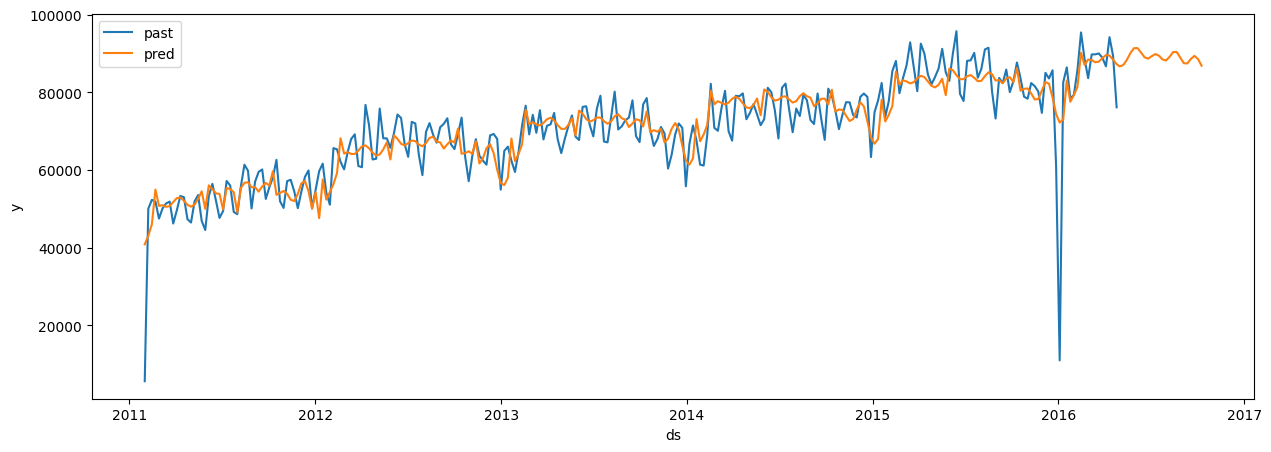

In [132]:
# representamos la prediccion respecto a los datos reales


plt.figure(figsize=(15, 5))
sns.lineplot(data=df_prophet_BOS_1,x='ds',y='y',label='past')

sns.lineplot(data=df_pred_BOS_1,x='ds',y='yhat',label='pred')

<Axes: xlabel='ds', ylabel='y'>

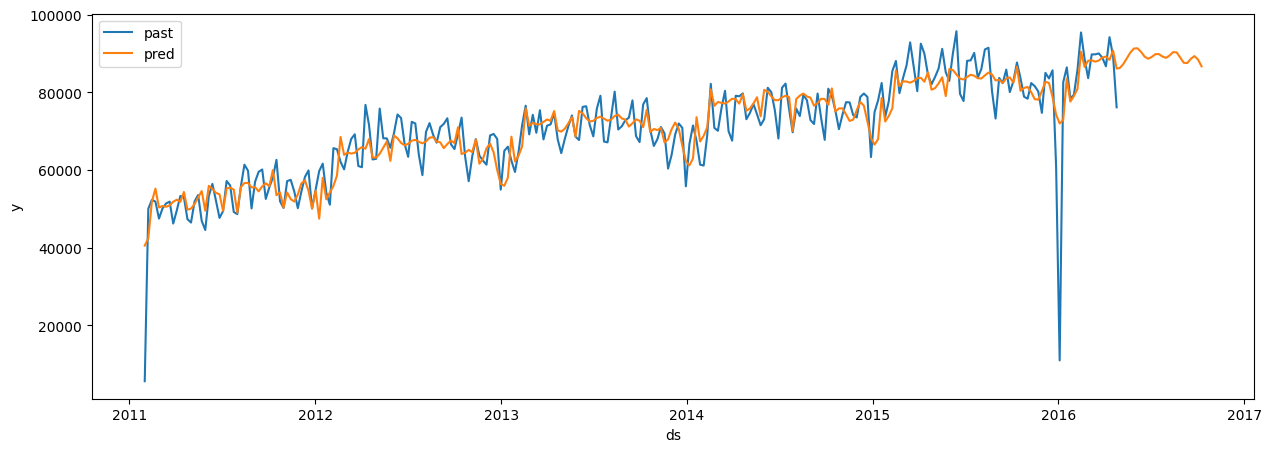

In [170]:
# representamos la prediccion respecto a los datos reales


plt.figure(figsize=(15, 5))
sns.lineplot(data=df_prophet_BOS_1,x='ds',y='y',label='past')

sns.lineplot(data=df_pred_BOS_1,x='ds',y='yhat',label='pred')

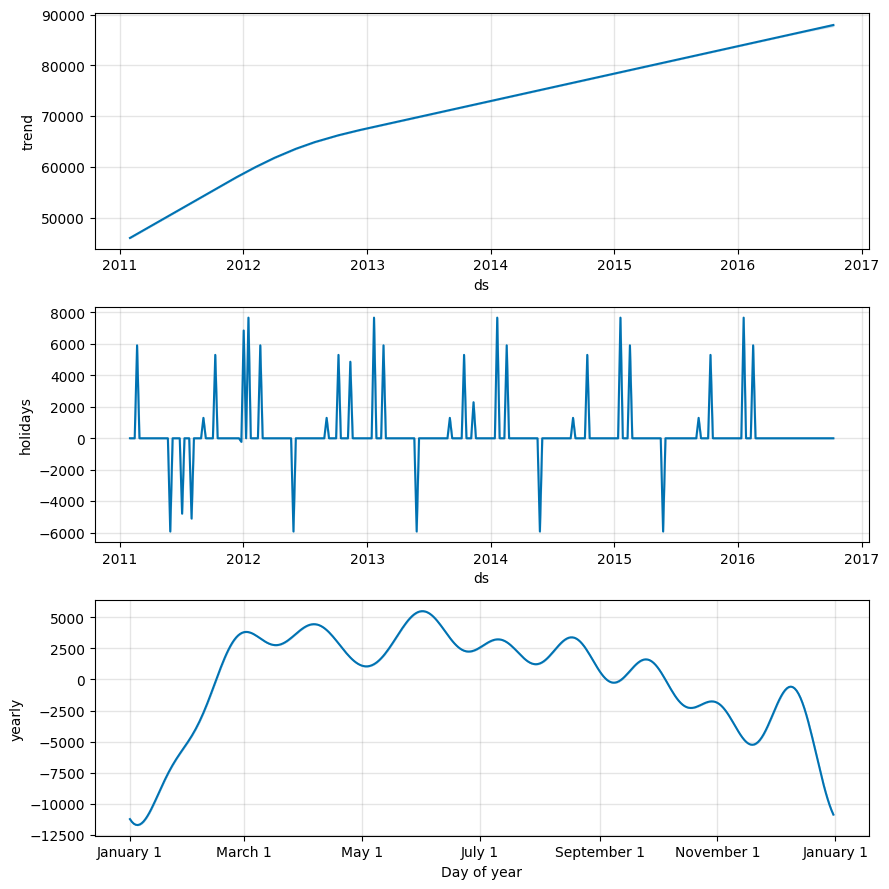

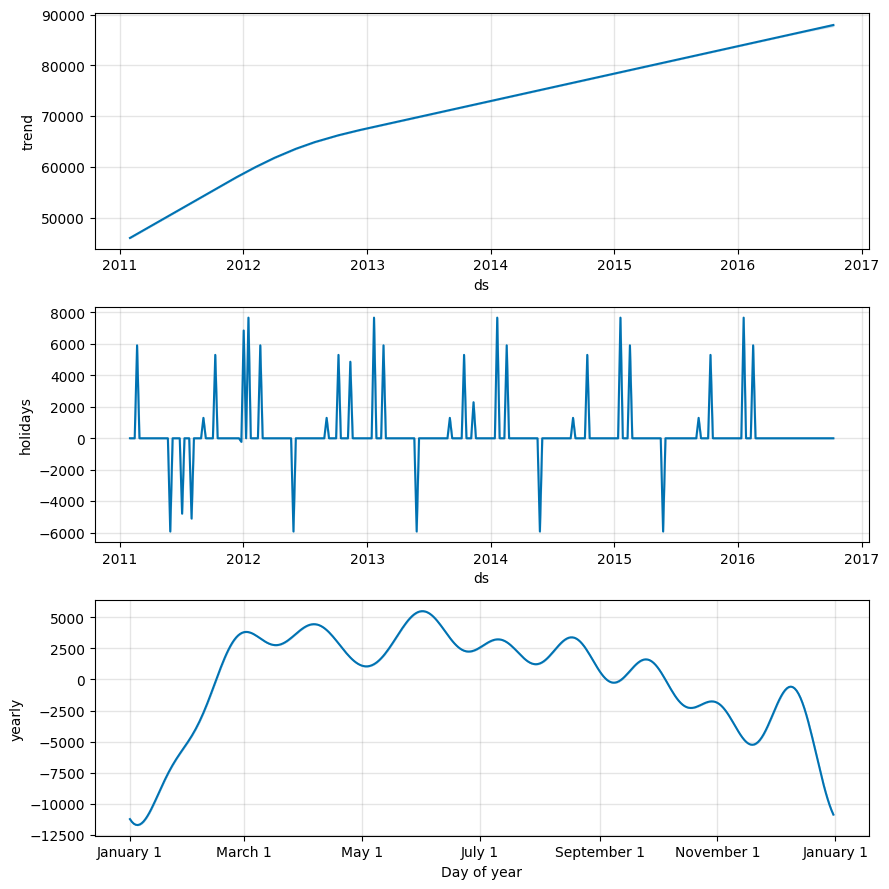

In [134]:
model.plot_components(df_pred_BOS_1)

In [17]:
# y hacemos la prediccion

df_pred_boston = model.make_future_dataframe(periods=len(df_South_End_BOS_1_test),freq='W')

<Axes: xlabel='date', ylabel='total_sales'>

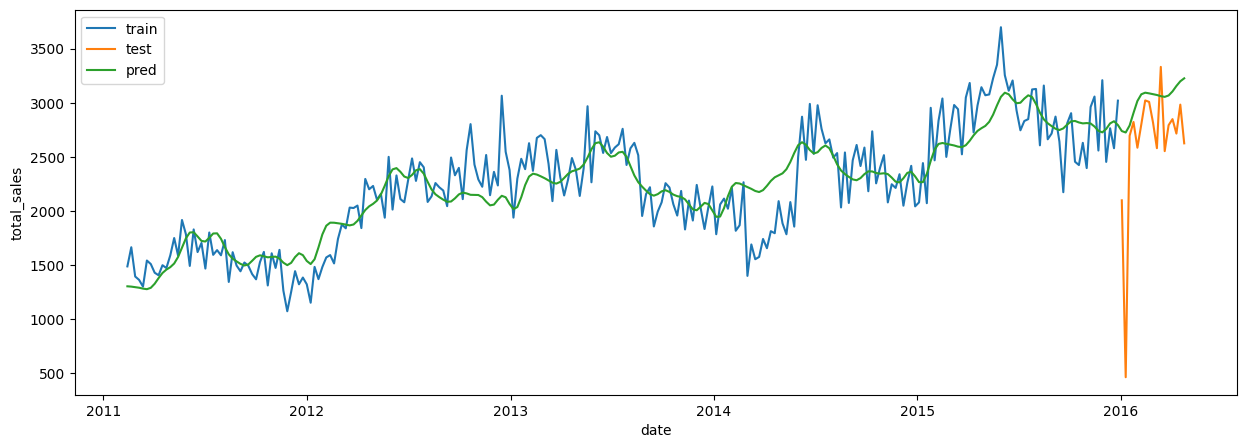

In [18]:
# representamos la prediccion respecto a los datos reales

df_pred_boston = model.predict(df_pred_boston)

plt.figure(figsize=(15, 5))

sns.lineplot(data=df_South_End_BOS_1_train.reset_index(),x='date',y='total_sales',label='train')
sns.lineplot(data=df_South_End_BOS_1_test.reset_index(),x='date',y='total_sales',label='test')
sns.lineplot(data=df_pred_boston,x='ds',y='yhat',label='pred')

In [19]:
# ahora haremos una prediccion para todo el 2016 y mitad del 2017

df_pred_boston_2 = model.make_future_dataframe(periods=80,freq='W')

<Axes: xlabel='date', ylabel='total_sales'>

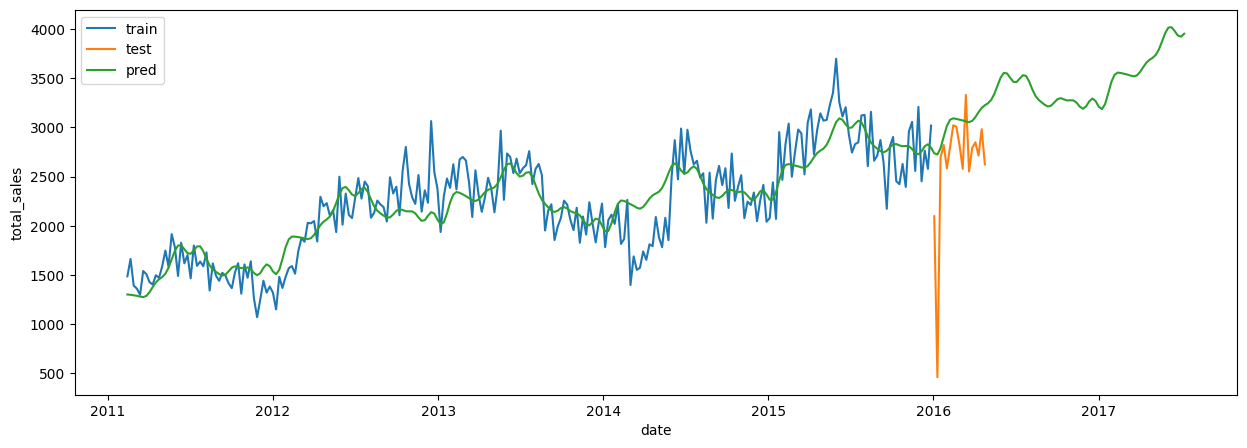

In [20]:
df_pred_boston_2 = model.predict(df_pred_boston_2)

plt.figure(figsize=(15, 5))

sns.lineplot(data=df_South_End_BOS_1_train.reset_index(),x='date',y='total_sales',label='train')
sns.lineplot(data=df_South_End_BOS_1_test.reset_index(),x='date',y='total_sales',label='test')
sns.lineplot(data=df_pred_boston_2,x='ds',y='yhat',label='pred')